In [1]:
import torch
import sys
from data import get_data, gen_label,createTestData
from tqdm import tqdm
import torch.nn as nn
import math
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
import cv2

class EncoderRNN(nn.Module):
    def __init__(self, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        # embedded = self.embedding(input).view(1, 1, -1)
        # output = embedded
        output, hidden = self.gru(inp, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size).cuda()


class CLSTMModel(torch.nn.Module):
    def __init__(self,feature_num,slidingWindow,InformationAdd,InformationLack):
        super(CLSTMModel, self).__init__()
        self.feature_num = feature_num
        self.cnn_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(512, self.feature_num)
        )

#         model = models.resnet18(pretrained=True)
# #         model.fc = nn.Identity()
#         self.cnn_layer = model
#         for p in self.parameters():
#             p.requires_grad=False
#         self.cnn_layer.fc = nn.Linear(512,self.feature_num)
        self.slidingWindow = slidingWindow
        self.InformationAdd = InformationAdd
        self.InformationLack = InformationLack
        self.lstm = nn.LSTM(self.feature_num,self.feature_num,1,batch_first=True,bidirectional=True,dropout=0.2)
        self.fc = nn.Linear(self.feature_num*2,1)
        self.slidingFc = nn.Linear(slidingWindow-self.InformationLack+self.InformationAdd,1)
        
        
    def forward(self, x, h0, c0):
        cnn_x = self.cnn_layer(x)
        batch = torch.zeros([0,self.slidingWindow-self.InformationLack+self.InformationAdd,self.feature_num])
        batch = batch.cuda()
        piece = torch.zeros([self.slidingWindow+self.InformationAdd-self.InformationLack,self.feature_num])
        piece = piece.cuda()
        piece[0:self.InformationAdd] = cnn_x[0:self.InformationAdd]
        for i in range(cnn_x.shape[0]-self.slidingWindow):
            piece[self.InformationAdd:] = cnn_x[i+self.InformationLack:i+self.slidingWindow]
            batch = torch.cat((batch,piece.view(1,self.slidingWindow-self.InformationLack+self.InformationAdd,self.feature_num)))
        # print("cnn_out",batch)
        # print(batch)
        # batch = self.sig(batch)
        x, (h_out, c_out) = self.lstm(batch)
        # h = h_out.permute(1, 0, 2)
        # h = h.reshape(h.shape[0], -1)
        # h = self.fc(h)
        
        b,s,h = x.shape
        x = x.reshape(s*b, h) # 转换成线性层的输入格式
        x = self.fc(x)
        x = x.reshape(b,s)
        x = self.slidingFc(x)
        x = x.view(b, -1)
        return x,0,0
        # return h, h_out, c_out   

slidingWindow = 10
seq_len = 10
InformationAdd = 0
InformationLack = 0
feature_num = 512
model = CLSTMModel(feature_num, slidingWindow, InformationAdd, InformationLack).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

batch_size = 256
epochs = 10
delay = 0

pbar = tqdm(range(1, epochs+1))
gt = []
pred= []

gen_label(seq_len, batch_size, True)  # 改变参数需要重新生成label，设reset=True
train_loader, test_loader = get_data(seq_len, batch_size, delay)
for epoch in pbar:
    h0 = torch.randn(2, batch_size-slidingWindow, feature_num).cuda()
    c0 = torch.randn(2, batch_size-slidingWindow, feature_num).cuda()
    for batch_index, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        labels = labels[slidingWindow:len(labels)].cuda()
        if labels.shape[0]!=batch_size-slidingWindow:
            continue
        optimizer.zero_grad()
        outputs, h0, c0 = model(images, h0, c0)
    
        loss = criterion(outputs.squeeze(1), labels)
        loss.backward()
        pbar.set_postfix({'train loss' : '{0:1.5f}'.format(loss)})
        optimizer.step()
        # cost = loss.item()
        # print("train lost:",cost)
        # break
        # print(cost)


ModuleNotFoundError: No module named 'torch'

In [3]:
from data import createTestData
import numpy as np
input = np.ones((1,50)).reshape(50)
input = input*5
input = input.tolist()
print(input)
images = createTestData(input)


[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)
(1, 3, 28, 28)

In [21]:
with torch.no_grad():
    h0 = torch.randn(1, batch_size-slidingWindow, feature_num).cuda()
    c0 = torch.randn(1, batch_size-slidingWindow, feature_num).cuda()
    for batch_index, (images, labels) in enumerate(test_loader):
        labels = labels[slidingWindow:len(labels)].cuda()
        images = images.cuda()
        if labels.shape[0]!=batch_size-slidingWindow:
            continue
        outputs, _, _ = model(images, h0, c0)
        pred.append(outputs.squeeze(1))
        gt.append(labels)
        
        loss = criterion(outputs, labels)
        cost = loss.item()
        print(cost)
        # pbar.set_postfix({'test loss' : '{0:1.5f}'.format(loss)})


0.028096819296479225
0.02622002176940441
0.02809431031346321
0.024220893159508705
0.027295293286442757
0.02961742877960205
0.028699208050966263
0.03199097141623497
0.019683733582496643
0.026645811274647713
0.03159444406628609
0.031955573707818985
0.03042699582874775
0.033398330211639404
0.03233901038765907
0.03944118320941925
0.037139590829610825
0.02373015694320202
0.03326570987701416
0.027794869616627693
0.032782528549432755
0.025198617950081825
0.028685616329312325
0.03186856210231781
0.028718704357743263
0.025261908769607544
0.02277396060526371
0.028009451925754547
0.027562985196709633
0.022421695291996002
0.03081541508436203
0.035543136298656464
0.025331631302833557
0.024694254621863365
0.025933053344488144
0.02633780613541603
0.034287262707948685
0.02490888349711895
0.03572770208120346


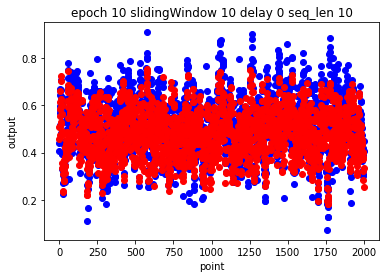

In [22]:
gt_show = [i.cpu().detach().numpy() for k in gt for i in k]
pred_show = [i.cpu().detach().numpy() for k in pred for i in k]
length = 2000
plt.scatter(list(range(length)), gt_show[0:length], c='b')
plt.scatter(list(range(length)), pred_show[0:length], c='r')
plt.xlabel('point')
plt.ylabel('output')
plt.title("epoch {} slidingWindow {} delay {} seq_len {}".format(epochs, slidingWindow+InformationAdd-InformationLack, delay, seq_len))
plt.show()
plt.close()

In [1]:
from data import gen_label
y = gen_label(5,1,256,True)

mean 0.13741155
var 0.0038471017
mean 0.50329196
var 0.049014937
mean 0.64606243
var 0.016965903
mean 0.50514734
var 0.0436029


(10000, 1)


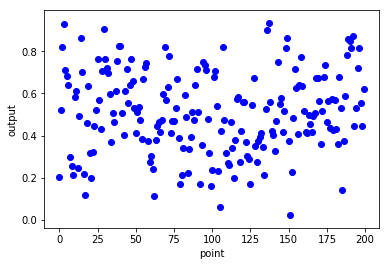

In [6]:
import matplotlib.pyplot as plt
print(y.shape)
# labels = [k.numpy() for k in y]
labels = y
length = 200

plt.scatter(list(range(length)), labels[:length], c='b')
# plt.plot(labels)
plt.xlabel('point')
plt.ylabel('output')
plt.show()
plt.close()

In [20]:
import torch
import sys
from data import get_data, gen_label
from tqdm import tqdm
import torch.nn as nn
import math
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
import cv2

class CLSTMModel(torch.nn.Module):
    def __init__(self,feature_num,slidingWindow,InformationAdd,InformationLack):
        super(CLSTMModel, self).__init__()
        self.feature_num = feature_num
        self.cnn_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(512, self.feature_num)
        )

#         model = models.resnet18(pretrained=True)
# #         model.fc = nn.Identity()
#         self.cnn_layer = model
#         for p in self.parameters():
#             p.requires_grad=False
#         self.cnn_layer.fc = nn.Linear(512,self.feature_num)
        self.slidingWindow = slidingWindow
        self.InformationAdd = InformationAdd
        self.InformationLack = InformationLack
        self.lstm = nn.LSTM(self.feature_num,self.feature_num,1,batch_first=True,bidirectional=True,dropout=0.2)
        self.fc = nn.Linear(self.feature_num*2,1)
        self.slidingFc = nn.Linear(slidingWindow-self.InformationLack+self.InformationAdd,1)
        
        
    def forward(self, x):
        cnn_x = self.cnn_layer(x)
        cnn_x = cnn_x.unsqueeze(0)
        x, (h_out, c_out) = self.lstm(cnn_x)
        # h = h_out.permute(1, 0, 2)
        # h = h.reshape(h.shape[0], -1)
        # h = self.fc(h)
        
        b,s,h = x.shape
        x = x.reshape(s*b, h) # 转换成线性层的输入格式
        x = self.fc(x)
        x = x.reshape(b,s)
        # x = self.slidingFc(x)
        # x = x.view(b, -1)
        return x
        # return h, h_out, c_out   

slidingWindow = 10
seq_len = 10
InformationAdd = 0
InformationLack = 0
feature_num = 512
model = CLSTMModel(feature_num, slidingWindow, InformationAdd, InformationLack).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

batch_size = 256
epochs = 10
delay = 10

pbar = tqdm(range(1, epochs+1))

system_dim = 50
output_dim = 1
gen_label(system_dim,output_dim,batch_size,False)  # 改变参数需要重新生成label，设reset=True
train_loader, test_loader = get_data(seq_len, batch_size, delay)
for epoch in pbar:
    # h0 = torch.randn(2, batch_size-slidingWindow, feature_num).cuda()
    # c0 = torch.randn(2, batch_size-slidingWindow, feature_num).cuda()
    for batch_index, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        optimizer.zero_grad()
        loss = criterion(outputs.squeeze(0), labels)
        loss.backward()
        pbar.set_postfix({'train loss' : '{0:1.5f}'.format(loss)})
        optimizer.step()


100%|██████████| 10/10 [02:07<00:00, 12.73s/it, train loss=0.13943]


In [22]:
gt = []
pred= []
train_gt = []
train_pred = []
with torch.no_grad():
    # h0 = torch.randn(1, batch_size-slidingWindow, feature_num).cuda()
    # c0 = torch.randn(1, batch_size-slidingWindow, feature_num).cuda()
    for batch_index, (images, labels) in enumerate(test_loader):
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        pred.append(outputs.squeeze(0))
        gt.append(labels)
        
        loss = criterion(outputs.squeeze(0), labels)
        cost = loss.item()
        print(cost)
        # pbar.set_postfix({'test loss' : '{0:1.5f}'.format(loss)})

0.03176495060324669
0.08586762845516205
0.07328542321920395
0.08497291058301926
0.13317792117595673
0.07497678697109222
0.14018988609313965
0.08672604709863663
0.0970013290643692
0.0962921530008316
0.07108410447835922
0.06764527410268784
0.06696507334709167
0.10339999198913574
0.09338805079460144
0.0837947428226471
0.11076266318559647
0.10172504186630249
0.1016564890742302
0.07286964356899261
0.06528306007385254
0.08246903121471405
0.04991307109594345
0.06260021775960922
0.0466233529150486
0.1292629837989807
0.07987142354249954
0.06283189356327057
0.05747908726334572
0.04453747719526291
0.04022938758134842
0.061236217617988586
0.0749521479010582
0.03755825757980347
0.03737737238407135
0.08836693316698074
0.05328158289194107
0.06534646451473236
0.09647364169359207
0.3064337372779846


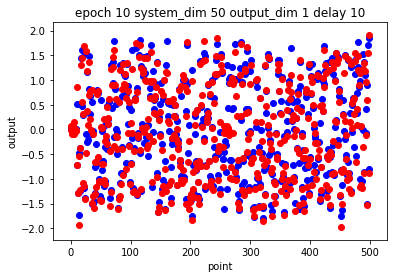

In [23]:
gt_show = [i.cpu().detach().numpy() for k in gt for i in k]
pred_show = [i.cpu().detach().numpy() for k in pred for i in k]
# train_gt_show = [i.cpu().detach().numpy() for k in train_gt for i in k]
# train_pred_show = [i.cpu().detach().numpy() for k in train_pred for i in k]
length = 500
# plt.scatter(list(range(length)), train_gt_show[0:length], c='b')
# plt.scatter(list(range(length)), train_pred_show[0:length], c='r')
plt.scatter(list(range(length)), gt_show[0:length+0], c='b')
plt.scatter(list(range(length)), pred_show[0:length+0], c='r')
plt.xlabel('point')
plt.ylabel('output')
plt.title("epoch {} system_dim {} output_dim {} delay {}".format(epochs, system_dim, output_dim, delay))
plt.show()
plt.close()


In [80]:
# 解A B C D
import torch
import matplotlib.pyplot as plt
 
input_size = 20
status_size = 20   #状态空间维度
output_size = 10
data_num = 1000
B = torch.randn(status_size, input_size)/output_size
A = torch.randn(status_size, status_size)/output_size
C = torch.randn(output_size,status_size)
D = torch.randn(output_size,input_size)
w = torch.cat((torch.cat((A,B),1),torch.cat((C,D),1)))
x = torch.zeros([status_size,1])
u = torch.zeros([input_size, 1])
inputs = torch.zeros([0, input_size+status_size, 1])
outputs = torch.zeros([0, status_size+output_size, 1])
for num in range(data_num):
    u = torch.randn(input_size, 1)
    # x = torch.randn(status_size,1)
    input = torch.cat((x,u),0)   #x(t),u
    y = torch.mm(C,x)+torch.mm(D,u)
    x = torch.mm(A,x)+torch.mm(B,u)
    output = torch.cat((x,y),0)   #x(t+1),y
    inputs = torch.cat((inputs, input.unsqueeze(0)))
    outputs = torch.cat((outputs, output.unsqueeze(0)))

print(inputs)
print(outputs)

tensor([[[ 0.0000],
         [ 0.0000],
         [ 0.0000],
         ...,
         [-1.5196],
         [ 0.1320],
         [ 0.9930]],

        [[-0.5377],
         [-0.3719],
         [ 0.0990],
         ...,
         [-0.8130],
         [-0.4907],
         [-0.0645]],

        [[-0.0361],
         [-0.7122],
         [-0.3701],
         ...,
         [-0.7764],
         [ 1.2879],
         [ 0.0959]],

        ...,

        [[-0.4421],
         [-0.6189],
         [ 0.2077],
         ...,
         [ 0.9360],
         [-1.4016],
         [-0.7313]],

        [[ 0.1721],
         [-0.2551],
         [-0.5344],
         ...,
         [ 0.4176],
         [ 0.6169],
         [-0.6892]],

        [[-0.0233],
         [-0.5850],
         [-0.6008],
         ...,
         [ 0.0038],
         [-0.2305],
         [ 0.1290]]])
tensor([[[ -0.5377],
         [ -0.3719],
         [  0.0990],
         ...,
         [  4.6677],
         [-10.4351],
         [ 10.7237]],

        [[ -0.0361],
       

In [83]:
import torch.nn as nn
class LinearRegression(nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(status_size+input_size, output_size+status_size) # 输入和输出的维度都是1
    def forward(self, x):
        out = self.linear(x)
        return out


model = LinearRegression().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=5e-2)

num_epochs = 200
for epoch in range(num_epochs):
    if torch.cuda.is_available():
        inputs = inputs.cuda()
        target = outputs.cuda()
    else:
        inputs = inputs
        target = outputs
    for i in range(len(inputs)):
        x = inputs[i]
        y = target[i]
        # 向前传播
        out = model(x.t())
        loss = criterion(out, y.t())
    
        # 向后传播
        optimizer.zero_grad() # 注意每次迭代都需要清零
        loss.backward()
        optimizer.step()
    
    if (epoch+1) %20 == 0:
        print('Epoch[{}/{}], loss:{:.6f}'.format(epoch+1, num_epochs, loss.item()))

Epoch[20/200], loss:0.000034
Epoch[40/200], loss:0.000002
Epoch[60/200], loss:0.000000
Epoch[80/200], loss:0.000000
Epoch[100/200], loss:0.000000
Epoch[120/200], loss:0.000000
Epoch[140/200], loss:0.000000
Epoch[160/200], loss:0.000000
Epoch[180/200], loss:0.000000
Epoch[200/200], loss:0.000000


In [84]:
model.eval()

w = model.state_dict()["linear.weight"]
AC_pred,BD_pred = w.split([status_size,input_size],1)
print(AC_pred.shape,BD_pred.shape)

A_pred,C_pred = AC_pred.split([status_size,output_size],0)
B_pred,D_pred = BD_pred.split([status_size,output_size],0)
print(A_pred.shape,B_pred.shape,C_pred.shape,D_pred.shape)
print(A.shape,B.shape,C.shape,D.shape)
A_bias = A_pred.cpu() - A
B_bias = B_pred.cpu() - B
C_bias = C_pred.cpu() - C
D_bias = D_pred.cpu() - D

print("A_max_bias:",A_bias.max(),A_bias.min())
print("B_max_bias:",B_bias.max(),B_bias.min())
print("C_max_bias:",C_bias.max(),C_bias.min())
print("D_max_bias:",D_bias.max(),D_bias.min())


# if torch.cuda.is_available():
#     predict = model(x.cuda())
#     predict = predict.data.cpu().numpy()
# else:
#     predict = model(Variable(x))
#     predict = predict.data.numpy()
# plt.plot(x.numpy(), y.numpy(), 'ro', label='Original Data')
# plt.plot(x.numpy(), predict, label='Fitting Line')
# plt.show()
# print(w)
# print(b)
# for name in model.state_dict():
#   print(name)


torch.Size([30, 20]) torch.Size([30, 20])
torch.Size([20, 20]) torch.Size([20, 20]) torch.Size([10, 20]) torch.Size([10, 20])
torch.Size([20, 20]) torch.Size([20, 20]) torch.Size([10, 20]) torch.Size([10, 20])
A_max_bias: tensor(8.0764e-06) tensor(-5.0068e-06)
B_max_bias: tensor(1.4901e-07) tensor(-1.9372e-07)
C_max_bias: tensor(4.9204e-05) tensor(-3.6955e-05)
D_max_bias: tensor(1.1921e-06) tensor(-1.4305e-06)
